In [638]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
import time

font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 28}
font1 = {'family': 'serif', 'size': 24}

First, we implement the LDSI example with synthetic random dataset as explained in the paper.

In [362]:
def proj(x,low=-5,high=5):

    x = np.clip(x, low, high)
    return x

def prox_l1(x, eta=1e-4, c=1e-4):
    threshold = c / eta
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def grad(func,x,mu=0.05,t=1):
    fx = func(x)
    g_avg = np.zeros_like(x)
    for i in range(t):
        u = np.random.normal(0,1, size=len(x))
        g = (func(x+mu*u)-fx)/mu*u
        g_avg += g
    g_avg /= t
    return g_avg


def step(func,x,h,mu=0.05,t=1):
    grd = grad(func,x,mu,t)
    xx = x - h*grd
    return xx

def RM(func,x0,T,h = 0.001,mu=0.05, t=1,flag2 = 'not_c',proj=None):
    dim1 = len(x0)
    x=np.zeros((dim1,T+1))
    x[:,0]=x0.ravel()
    if flag2 == 'not_c':
        for k in range(T):
          x[:,k+1] = step(func,x[:,k],h,mu,t)
    if flag2 == 'c':
        for k in range(T):
          x[:,k+1] =proj(step(func,x[:,k],h,mu,t))
    return x

def f(x):
    return np.sum(x**4 + x**2)
x0 = np.array([5, -5])
print("final X with g",RM(f,x0,10000,h = 0.001,t=10,mu=0.001)[:,-1])

final X with g [ 7.72467114e-07 -1.09304214e-05]


In [429]:
N = 100
T = 500
d = 20
T1 = T // 4
epsilon = 0.1


def create_matrix_A(n, rho_max=0.8):
    # Sample stable eigenvalues inside the unit circle
    radii = rho_max * np.random.rand(n)
    angles = 2 * np.pi * np.random.rand(n)
    eigs = radii * np.exp(1j * angles)

    # Get real polynomial coefficients
    coeffs = np.poly(eigs).real  # characteristic polynomial
    a = coeffs[1:]               # skip leading 1

    # Companion matrix
    A = np.zeros((n, n))
    np.fill_diagonal(A[:, 1:], 1)
    A[-1] = -a[::-1]

    return A


def spectral_radius(matrix):
    """
    Calculate the spectral radius of a matrix.
    """
    eigenvalues, _ = np.linalg.eig(matrix)
    return max(abs(eigenvalues))





def generate_training_data(N, T, d):
    """
    Generate training data according to the given specifications.
    """

    # Generate input sequences x and output sequences y
    x = np.random.randn(N, T)
    y = np.zeros((N, T))
    h = np.zeros((N, T+1, d))  # Hidden states
    for i in range(N):
        for t in range(T):
            h[i, t+1] = (np.dot(A, h[i, t]).reshape(-1, 1)+ np.dot(B, x[i, t])).ravel()
            y[i, t] = np.dot(C, h[i, t]).item() + np.dot(D, x[i, t]).item() + 0.01*np.random.randn()
    
    return x, y

def combine_params(A, C, D):
    # Flatten matrix A to a 1D array
    A_flat = A.flatten().reshape(-1,1)
    
    # Concatenate A_flat, C, and D into a single vector
    combined_vector = np.concatenate((A_flat, C.T, [D]))

    return combined_vector

def split_params(combined_vector, d):
    # Extract matrix A from combined_vector
    A_size = d * d
    A = combined_vector[:A_size].reshape(d, d)

    # Extract vector C from combined_vector
    C = combined_vector[A_size:A_size + d].reshape(1, d)

    # Extract scalar D from combined_vector
    D = combined_vector[-1]

    return A, C, D


def evaluate_loss(theta_hat_0):
    """
    Evaluate the loss function for the given parameters theta_hat.
    """
    A_hat, C_hat, D_hat = split_params(theta_hat_0,d)
    M = x.shape[0]  # Number of training examples
    T = x.shape[1]  # Length of each sequence
    
    loss = 0
    for i in range(M):
        h_hat = np.zeros((T+1, d))  # Estimated hidden states        
    
        for t in range(T1, T):
            h_hat[t+1] = (np.dot(A_hat, h_hat[t]).reshape(-1, 1)+ np.dot(B, x[i, t])).ravel()
            y_hat = np.dot(C_hat, h_hat[t]) + np.dot(D_hat, x[i, t])
            loss += np.linalg.norm(y_hat - y[i, t])**2
    
    loss /= (M * (T - T1))
    
    return loss

def perturb_parameters(true_A, true_C, true_D, epsilon):
    """
    Perturb the true parameters to obtain perturbed parameters while
    ensuring the spectral radius of A_hat is less than 1.
    """
    while True: 
        A_hat = create_matrix_A(d, rho_max=0.4) 
        A_hat[-1,:] = true_A[-1,:] + epsilon * np.random.randn(d)
        if spectral_radius(A_hat) < 1:
            break
    
    C_hat = true_C + epsilon * np.random.randn(*true_C.shape)
    D_hat = true_D + epsilon * np.random.randn(*true_D.shape)
    
    return A_hat, C_hat, D_hat

def gradient_loss(theta_hat):
    """
    Analytic gradient of the same loss wrt (A,C,D), packed as theta_hat.
    """
    A_hat, C_hat, D_hat = split_params(theta_hat, d)
    M = x.shape[0]
    Tloc = x.shape[1]

    grad_A = np.zeros((d, d))
    grad_C = np.zeros((1, d))
    grad_D = 0.0

    for i in range(M):
        h_hat = np.zeros((Tloc + 1, d))
        for t in range(T1, Tloc):
            h_hat[t + 1] = (A_hat @ h_hat[t] + (B * x[i, t]).reshape(-1)).ravel()
            y_hat = (C_hat @ h_hat[t]).item() + D_hat * x[i, t]
            err = y_hat - y[i, t]

            # d/dD
            grad_D += 2.0 * err * x[i, t]
            # d/dC
            grad_C += 2.0 * err * h_hat[t].reshape(1, -1)
            # d/dA: use outer product C_hat^T (d,1) with h_hat[t-1] (1,d)
            grad_A += 2.0 * err * (C_hat.T @ h_hat[t-1].reshape(1, -1))

    grad_A /= (M * (Tloc - T1))
    grad_C /= (M * (Tloc - T1))
    grad_D /= (M * (Tloc - T1))

    return combine_params(grad_A, grad_C, grad_D)

for i in range(10):
    AA = create_matrix_A(d, rho_max=0.4)
    print(spectral_radius(AA))
    if spectral_radius(AA) < 1:
        A = AA
        break
    
B = np.zeros((d, 1))
B[-1] = 1

C = np.random.randn(1, d)
D = np.random.randn(1)

x, y= generate_training_data(N, T, d)
# Perturb parameters
A_hat_0, C_hat_0, D_hat_0 = perturb_parameters(A, C, D, epsilon)

theta_hat_0 = combine_params(A_hat_0, C_hat_0, D_hat_0)
loss = evaluate_loss(theta_hat_0)
print("Loss:", loss)
# print("gradient", gradient_loss(w[0,:].reshape(-1,1)))

num_iterations = 500
learning_rate = 1e-5
learning_rate2 = 1e-6
num_iterations2 = 500

0.4150329317966432
Loss: 6.656110766026163


In [438]:
MC = 4
execution_time = []
execution_time2 = []
execution_time3 = []
f1 = np.zeros((num_iterations,MC))
losses = np.zeros((num_iterations2,MC))
losses2 = np.zeros((num_iterations2,MC))
for i in range(10):
    AA = create_matrix_A(d, rho_max=0.35)
    print(spectral_radius(AA))
    if spectral_radius(AA) < 1:
        A = AA
        break
    
B = np.zeros((d, 1))
B[-1] = 1

C = np.random.randn(1, d)
D = np.random.randn(1)

x, y= generate_training_data(N, T, d)

for j in range(MC):
    # Perturb parameters
    A_hat_0, C_hat_0, D_hat_0 = perturb_parameters(A, C, D, epsilon)
    theta_hat_0 = combine_params(A_hat_0, C_hat_0, D_hat_0)
    print("A_0 spectral radius:", spectral_radius(A_hat_0))
    print("Initial loss:",evaluate_loss(theta_hat_0))
    start = time.time()
    ww=RM(evaluate_loss,theta_hat_0,num_iterations,h = 1e-6,mu=1e-6)
    end = time.time()
    execution_time.append(end-start)

    for i in range(num_iterations):
        f1[i,j] = evaluate_loss(ww[:,i])

    w = np.zeros((num_iterations2,np.shape(theta_hat_0)[0]))
    w[0,:]=theta_hat_0.ravel()

    # Gradient Descent
    start = time.time()
    for i in range(num_iterations2-1):
        # Compute gradient
        grad_theta = gradient_loss(w[i,:].reshape(-1,1)).ravel()
        # Update weights
        w[i+1,:] =w[i,:]-learning_rate * grad_theta
        # Compute loss
    end = time.time()
    execution_time2.append(end-start)

    for i in range(num_iterations2):
        # Compute loss
        current_loss = evaluate_loss(w[i,:])
        losses[i,j] = current_loss

    w1 = np.zeros((num_iterations2,np.shape(theta_hat_0)[0]))
    w1[0,:]=theta_hat_0.ravel()

    # Gradient Descent
    start = time.time()
    for i in range(num_iterations2-1):
        # Compute gradient
        grad_theta = gradient_loss(w1[i,:].reshape(-1,1)).ravel()
        # if np.linalg.norm(grad_theta)>=50:
        #     grad_theta = grad_theta/np.linalg.norm(grad_theta)*10
        # Update weights
        w1[i+1,:] =w1[i,:]-learning_rate2 * grad_theta
        # Compute loss
    end = time.time()
    execution_time3.append(end-start)

    for i in range(num_iterations2):
        # Compute loss
        current_loss = evaluate_loss(w1[i,:])
        losses2[i,j] = current_loss

    print(f"MC iteration {j+1} completed.")

0.28017396112805076
A_0 spectral radius: 0.9824691175342314
Initial loss: 8.688471828035567
MC iteration 1 completed.
A_0 spectral radius: 0.9840226909162102
Initial loss: 36.467834197951696
MC iteration 2 completed.
A_0 spectral radius: 0.9659119154894716
Initial loss: 5.691184735914661
MC iteration 3 completed.
A_0 spectral radius: 0.9308837348070778
Initial loss: 7.980786842217653
MC iteration 4 completed.


In [439]:
et = np.mean(execution_time)
et2 = np.mean(execution_time2)
et3 = np.mean(execution_time3)
tim = np.linspace(0,et,num_iterations)
tim2 = np.linspace(0,et2,num_iterations2)
tim3 = np.linspace(0,et3,num_iterations2)
f1_a = np.mean(f1,axis=1)
losses_a = np.mean(losses,axis=1)
losses2_a = np.mean(losses2,axis=1)

f1_se = np.std(f1, axis=1)
losses_se = np.std(losses, axis=1)
losses2_se = np.std(losses2, axis=1)

In [427]:
# np.save('RM_losses.npy', f1)
# np.save('GD_losses.npy', losses)
# np.save('GD_losses_clip.npy', losses2)
# np.save('tim.npy', tim)
# np.save('tim2.npy', tim2)
# np.save('tim3.npy', tim3)
# np.save('et.npy',execution_time)
# np.save('et2.npy',execution_time2)
# np.save('et3.npy',execution_time3)

# f1 = np.load('RM_losses.npy')
# losses = np.load('GD_losses.npy')
# losses2 = np.load('GD_losses_clip.npy')
# f1_a = np.mean(f1,axis=1)
# losses_a = np.mean(losses,axis=1)
# losses2_a = np.mean(losses2,axis=1)
# tim = np.load('tim.npy')
# tim2 = np.load('tim2.npy')
# tim3 = np.load('tim3.npy')
# num_iterations = 1000
# num_iterations2= 1000

# f1_se = np.std(f1, axis=1)
# losses_se = np.std(losses, axis=1)
# losses2_se = np.std(losses2, axis=1)

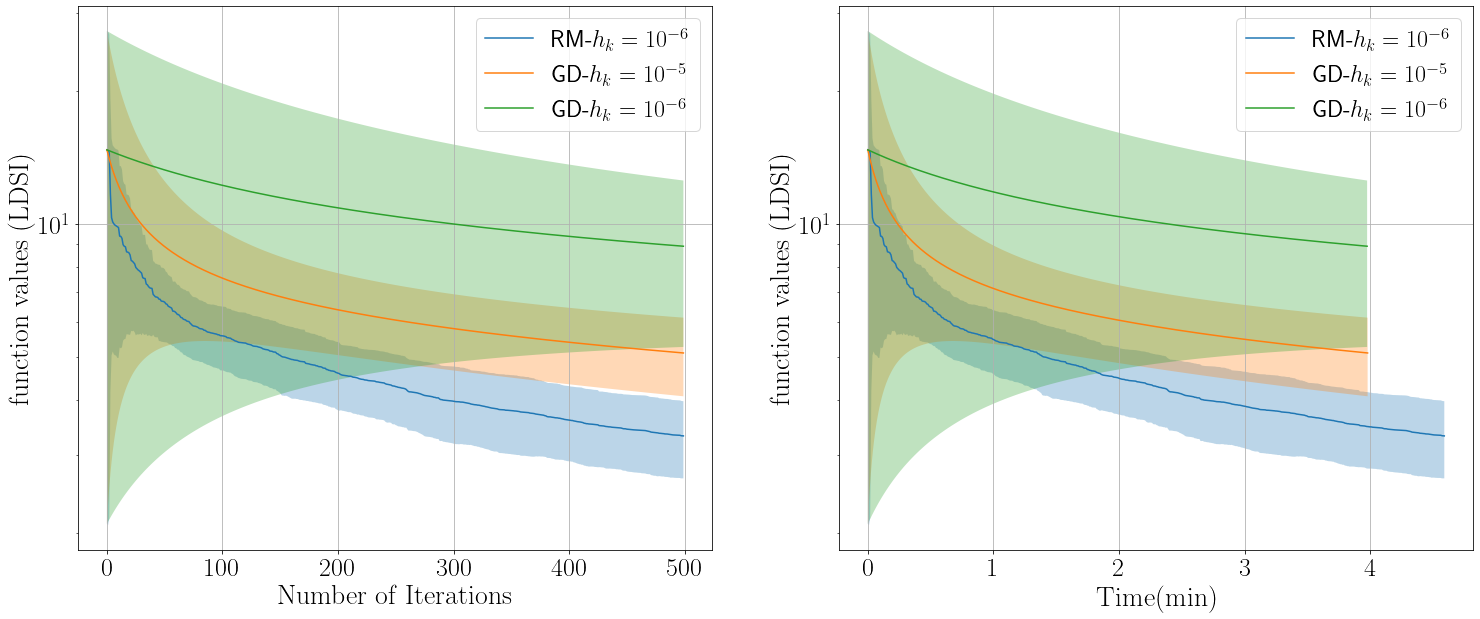

In [ ]:
t = np.array(range(num_iterations))
t2 = np.array(range(num_iterations2))
plt.figure(figsize=(25,10))
plt.subplot(1, 2, 1)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(t,f1_a,label= r'RM-$h_k = 10^{-6}$')
plt.plot(t2,losses_a,label= r'GD-$h_k = 10^{-5}$')
plt.plot(t2,losses2_a,label= r'GD-$h_k = 10^{-6}$')

plt.fill_between(t, f1_a - f1_se, f1_a + f1_se, alpha=0.3)
plt.fill_between(t2, losses_a - losses_se, losses_a + losses_se, alpha=0.3)
plt.fill_between(t2, losses2_a - losses2_se, losses2_a + losses2_se, alpha=0.3)

plt.xlabel(r'$\mathrm{Number\; of\; Iterations}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(LDSI)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.grid('on')
plt.legend(loc='best', prop=font1)

plt.subplot(1, 2, 2)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(tim/60,f1_a,label= r'RM-$h_k = 10^{-6}$')
plt.plot(tim2/60,losses_a,label= r'GD-$h_k = 10^{-5}$')
plt.plot(tim3/60,losses2_a,label= r'GD-$h_k = 10^{-6}$')

plt.fill_between(tim/60, f1_a - f1_se, f1_a + f1_se, alpha=0.3)
plt.fill_between(tim2/60, losses_a - losses_se, losses_a + losses_se, alpha=0.3)
plt.fill_between(tim3/60, losses2_a - losses2_se, losses2_a + losses2_se, alpha=0.3)

plt.xlabel(r'$\mathrm{Time(min)}$', fontsize=28)
plt.ylabel(r'$\mathrm{function\; values\;(LDSI)}$', fontdict=font)
plt.yscale('log')
# plt.xscale('log')
plt.legend(loc='best', prop=font1)
plt.grid('on')
# plt.savefig('LDSI_rand.pdf', format='pdf')

Below we try to do the LDSI for a small physical system of a mass spring damper with several dummy states. (Not included in the draft)

In [621]:
def proj(x, low=-5, high=5):
    return np.clip(x, low, high)


def grad(func, x, mu=0.05, t=1, fxp=None):
    if fxp is None:
        fx = func(x)
    else:
        fx = fxp
    g_avg = np.zeros_like(x)
    for _ in range(t):
        u = np.random.normal(0, 1, size=len(x))
        g = (func(x + mu * u) - fx) / mu * u
        g_avg += g
    g_avg /= t
    return g_avg


def step(func, x, h, mu=0.05, t=1):
    g = grad(func, x, mu, t)
    return x - h * g


def RM(func, x0, T, h=0.001, mu=0.05, t=1, flag2='not_c', proj=None):
    dim = len(x0)
    x = np.zeros((dim, T + 1))
    x[:, 0] = x0.ravel()
    if flag2 == 'not_c':
        for k in range(T):
            x[:, k + 1] = step(func, x[:, k], h, mu, t)
    elif flag2 == 'c':
        for k in range(T):
            x[:, k + 1] = proj(step(func, x[:, k], h, mu, t))
    return x

def spectral_radius(matrix):
    eigvals = np.linalg.eigvals(matrix)
    return np.max(np.abs(eigvals))


def generate_training_data(A, B, C, D, N, T, d, T1, noise_std=0.01):
    """
    Generates N sequences of length T from the LDS:
        x_{t+1} = A x_t + B u_t
        y_t     = C x_t + D u_t + noise
    where u_t ~ N(0,1).
    """
    x_in = np.random.randn(N, T)
    y_out = np.zeros((N, T))
    h = np.zeros((N, T + 1, d))
    for i in range(N):
        for t in range(T):
            h[i, t + 1] = (A @ h[i, t] + (B * x_in[i, t]).reshape(-1)).ravel()
            y_out[i, t] = (C @ h[i, t]).item() + D * x_in[i, t] + noise_std * np.random.randn()
    return x_in, y_out


def combine_params(A, C, D):
    A_flat = A.flatten().reshape(-1, 1)         # (d^2, 1)
    C_flat = C.reshape(-1, 1)                   # (d, 1)
    D_flat = np.array([[D]])                    # (1, 1)
    return np.concatenate((A_flat, C_flat, D_flat))

def split_params(theta, d):
    A_size = d * d
    A = theta[:A_size].reshape(d, d)
    C_flat = theta[A_size:A_size + d]           # (d, 1)
    C = C_flat.reshape(1, d)                    # (1, d)
    D = float(theta[-1].item())                  # scalar
    return A, C, D



In [444]:
N = 200
T = 300
d = 4
T1 = T // 4

# Physical parameters for mass-spring-damper
m = 1.0
k = 2.0
c = 0.4
Ts = 0.05

# Discrete-time 2D system (Euler or similar)
A2 = np.array([[1.0, Ts],
               [-k / m * Ts, 1.0 - c / m * Ts]])
B2 = np.array([[0.0],
               [Ts / m]])
C2 = np.array([[1.0, 0.0]])
D2 = 0.0
print("Spectral radius of A_2:", spectral_radius(A2))

# Stabilise A2 if needed
rho2 = spectral_radius(A2)
if rho2 >= 1.0:
    A2 = A2 / (rho2 + 0.05)

# Embed into d=20
A_true = np.eye(d) * 0.5
A_true[:2, :2] = A2
B_true = np.zeros((d, 1))
B_true[:2, :1] = B2
C_true = np.zeros((1, d))
C_true[0, :2] = C2
D_true = D2

print("Spectral radius of A_true:", spectral_radius(A_true))

# Generate training data from the real system
x, y = generate_training_data(A_true, B_true, C_true, D_true, N, T, d, T1, noise_std=0.01)

Spectral radius of A_2: 0.9924716620639603
Spectral radius of A_true: 0.9924716620639603


In [445]:
def evaluate_loss(theta_hat):
    """
    Loss:
        (1 / (N (T - T1))) sum_{i} sum_{t=T1}^{T-1} (y_hat - y)^2
    with model:
        x_{t+1} = A_hat x_t + B_true u,
        y_hat   = C_hat x_t + D_hat u.
    """
    A_hat, C_hat, D_hat = split_params(theta_hat, d)
    M = x.shape[0]
    Tloc = x.shape[1]

    loss = 0.0
    for i in range(M):
        h_hat = np.zeros((Tloc + 1, d))
        for t in range(T1, Tloc):
            h_hat[t + 1] = (A_hat @ h_hat[t] + (B_true * x[i, t]).reshape(-1)).ravel()
            # C_hat: (1,d), h_hat[t]: (d,), result scalar
            y_hat = (C_hat @ h_hat[t]).item() + D_hat * x[i, t]
            loss += (y_hat - y[i, t]) ** 2
    loss /= (M * (Tloc - T1))
    return loss


def gradient_loss(theta_hat):
    """
    Analytic gradient of the same loss wrt (A,C,D), packed as theta_hat.
    """
    A_hat, C_hat, D_hat = split_params(theta_hat, d)
    M = x.shape[0]
    Tloc = x.shape[1]

    grad_A = np.zeros((d, d))
    grad_C = np.zeros((1, d))
    grad_D = 0.0

    for i in range(M):
        h_hat = np.zeros((Tloc + 1, d))
        for t in range(T1, Tloc):
            h_hat[t + 1] = (A_hat @ h_hat[t] + (B_true * x[i, t]).reshape(-1)).ravel()
            y_hat = (C_hat @ h_hat[t]).item() + D_hat * x[i, t]
            err = y_hat - y[i, t]

            # d/dD
            grad_D += 2.0 * err * x[i, t]
            # d/dC
            grad_C += 2.0 * err * h_hat[t].reshape(1, -1)
            # d/dA: use outer product C_hat^T (d,1) with h_hat[t-1] (1,d)
            grad_A += 2.0 * err * (C_hat.T @ h_hat[t-1].reshape(1, -1))

    grad_A /= (M * (Tloc - T1))
    grad_C /= (M * (Tloc - T1))
    grad_D /= (M * (Tloc - T1))

    return combine_params(grad_A, grad_C, grad_D)

In [305]:
np.random.seed()
epsilon = 0.1

A_hat_0 = A_true + epsilon * np.random.randn(*A_true.shape)
rho_hat = spectral_radius(A_hat_0)
if rho_hat >= 1.0:
    A_hat_0 = A_hat_0 / (rho_hat + 0.05)
print("Spectral radius of A_0:", spectral_radius(A_hat_0))
C_hat_0 = C_true + epsilon * np.random.randn(*C_true.shape)
D_hat_0 = D_true + epsilon * np.random.randn()

theta_hat_0 = combine_params(A_hat_0, C_hat_0, D_hat_0)

init_loss = evaluate_loss(theta_hat_0)
print("Initial loss:", init_loss)

Spectral radius of A_0: 0.9551386722723431
Initial loss: 0.04224305763260632


In [306]:
num_iterations_rm = 1200
num_iterations_gd = 1200
learning_rate_gd1 = 1e-2     # larger step
learning_rate_gd2 = 2e-3     # smaller step

# RM
start = time.time()
rm_traj = RM(evaluate_loss, theta_hat_0, num_iterations_rm,
             h=2e-3, mu=1e-8, t=1)
rm_time = time.time() - start

rm_losses = np.array([evaluate_loss(rm_traj[:, k])
                      for k in range(num_iterations_rm + 1)])
rm_best_idx = np.argmin(rm_losses)
rm_best = rm_traj[:, rm_best_idx]

print("RM: best loss:", rm_losses[rm_best_idx])
print("RM: final loss:", rm_losses[-1])
print("RM: time (s):", rm_time)

# GD with larger step
w1 = np.zeros((num_iterations_gd, theta_hat_0.size))
w1[0, :] = theta_hat_0.ravel()

start = time.time()
for it in range(num_iterations_gd - 1):
    g = gradient_loss(w1[it, :].reshape(-1, 1)).ravel()
    w1[it + 1, :] = w1[it, :] - learning_rate_gd1 * g
gd1_time = time.time() - start

gd1_losses = np.array([evaluate_loss(w1[it, :])
                       for it in range(num_iterations_gd)])

gd1_best_idx = np.argmin(gd1_losses)
gd1_best = w1[gd1_best_idx, :]

print("GD (lr=1e-2): final loss:", gd1_losses[-1])
print("GD (lr=1e-2): best loss:", gd1_losses[gd1_best_idx])
print("GD (lr=1e-2): time (s):", gd1_time)


# GD with smaller step
w2 = np.zeros((num_iterations_gd, theta_hat_0.size))
w2[0, :] = theta_hat_0.ravel()

start = time.time()
for it in range(num_iterations_gd - 1):
    g = gradient_loss(w2[it, :].reshape(-1, 1)).ravel()
    w2[it + 1, :] = w2[it, :] - learning_rate_gd2 * g
gd2_time = time.time() - start

gd2_losses = np.array([evaluate_loss(w2[it, :])
                       for it in range(num_iterations_gd)])

gd2_best_idx = np.argmin(gd2_losses)
gd_best = w2[gd2_best_idx, :]

print("GD (lr=2e-3): best loss:", gd2_losses[gd2_best_idx])
print("GD (lr=2e-3): final loss:", gd2_losses[-1])
print("GD (lr=2e-3): time (s):", gd2_time)

RM: best loss: 0.008345925539872132
RM: final loss: 0.008345925539872132
RM: time (s): 382.9760661125183
GD (lr=1e-2): final loss: 0.029159028607192564
GD (lr=1e-2): best loss: 0.029159028607192564
GD (lr=1e-2): time (s): 381.97753620147705
GD (lr=5e-3): best loss: 0.03360249878156781
GD (lr=5e-3): final loss: 0.03360249878156781
GD (lr=5e-3): time (s): 368.35614562034607


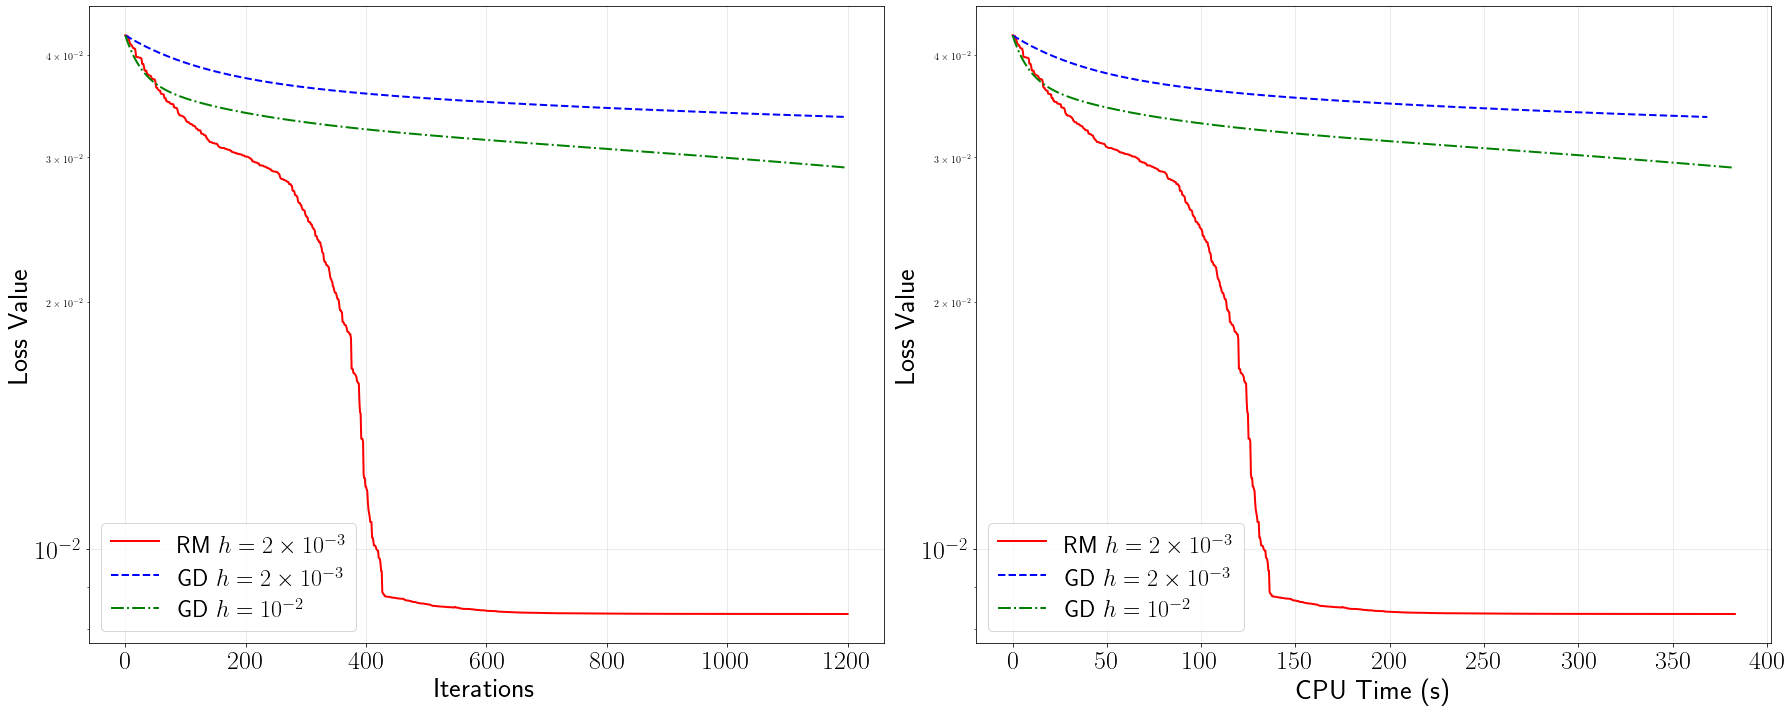

In [327]:
import matplotlib.pyplot as plt

# Plot losses vs iterations
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.semilogy(range(len(rm_losses)), rm_losses, 'r-', linewidth=2, label=r'RM $h=2\times 10^{-3}$')
plt.semilogy(range(len(gd2_losses)), gd2_losses, 'b--', linewidth=2, label=r'GD $h=2\times 10^{-3}$')
plt.semilogy(range(len(gd1_losses)), gd1_losses, 'g-.', linewidth=2, label=r'GD $h=10^{-2}$')
plt.xlabel('Iterations', fontdict=font)
plt.ylabel('Loss Value', fontdict=font)
# plt.title('LDSI Loss vs Iterations')
plt.legend(loc='best', prop=font1)
plt.grid(True, alpha=0.3)

# Plot losses vs CPU time
rm_cumtime = np.linspace(0, rm_time, len(rm_losses))
gd1_cumtime = np.linspace(0, gd1_time, len(gd1_losses))
gd2_cumtime = np.linspace(0, gd2_time, len(gd2_losses))

plt.subplot(1, 2, 2)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.semilogy(rm_cumtime, rm_losses, 'r-', linewidth=2, label=r'RM $h=2\times 10^{-3}$')
plt.semilogy(gd2_cumtime, gd2_losses, 'b--', linewidth=2, label=r'GD $h=2\times 10^{-3}$')
plt.semilogy(gd1_cumtime, gd1_losses, 'g-.', linewidth=2, label=r'GD $h=10^{-2}$')
plt.xlabel('CPU Time (s)', fontdict=font)
plt.ylabel('Loss Value', fontdict=font)
# plt.title('LDSI Loss vs CPU Time')
plt.legend(loc='best', prop=font1)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('LDSI_physical_losses.pdf', bbox_inches='tight')


In [308]:
def simulate_system(A, B, C, D, u):
    """
    Simulate one trajectory:
        x_{t+1} = A x_t + B u_t
        y_t     = C x_t + D u_t
    with x_0 = 0.
    """
    dloc = A.shape[0]
    Tloc = u.size
    x_state = np.zeros((Tloc + 1, dloc))
    y_out = np.zeros(Tloc)
    for t in range(Tloc):
        x_state[t + 1] = (A @ x_state[t] + (B * u[t]).reshape(-1)).ravel()
        y_out[t] = (C @ x_state[t]).item() + D * u[t]
    return x_state, y_out

In [341]:
T_test = 500
u_test = np.random.randn(T_test)

# True system and initial guess
x_true, y_true = simulate_system(A_true, B_true, C_true, D_true, u_test)
x_0, y_0 = simulate_system(A_hat_0, B_true, C_hat_0, D_hat_0, u_test)

# RM system (best iterate)
A_rm, C_rm, D_rm = split_params(rm_best, d)
C_rm = C_rm.reshape(1, -1)
_, y_rm = simulate_system(A_rm, B_true, C_rm, D_rm, u_test)

# GD system (best of small-step GD)
A_gd, C_gd, D_gd = split_params(gd_best, d)
C_gd = C_gd.reshape(1, -1)
_, y_gd = simulate_system(A_gd, B_true, C_gd, D_gd, u_test)

# GD system (best of large-step GD)
A_gd1, C_gd1, D_gd1 = split_params(gd1_best, d)
C_gd1 = C_gd1.reshape(1, -1)
_, y_gd1 = simulate_system(A_gd1, B_true, C_gd1, D_gd1, u_test)

mse_00 = np.mean((y_0 - y_true) ** 2)
mse_rm = np.mean((y_rm - y_true) ** 2)
mse_gd = np.mean((y_gd - y_true) ** 2)
mse_gd1 = np.mean((y_gd1 - y_true) ** 2)

print("Test MSE (initial guess vs true):", mse_00)
print("Test MSE (RM vs true):", mse_rm)
print("Test MSE (GD vs true):", mse_gd)
print("Test MSE (GD-l vs true):", mse_gd1)

Test MSE (initial guess vs true): 0.020621727781804787
Test MSE (RM vs true): 6.583300373788622e-06
Test MSE (GD vs true): 0.013598243808309644
Test MSE (GD-l vs true): 0.010416283653789297


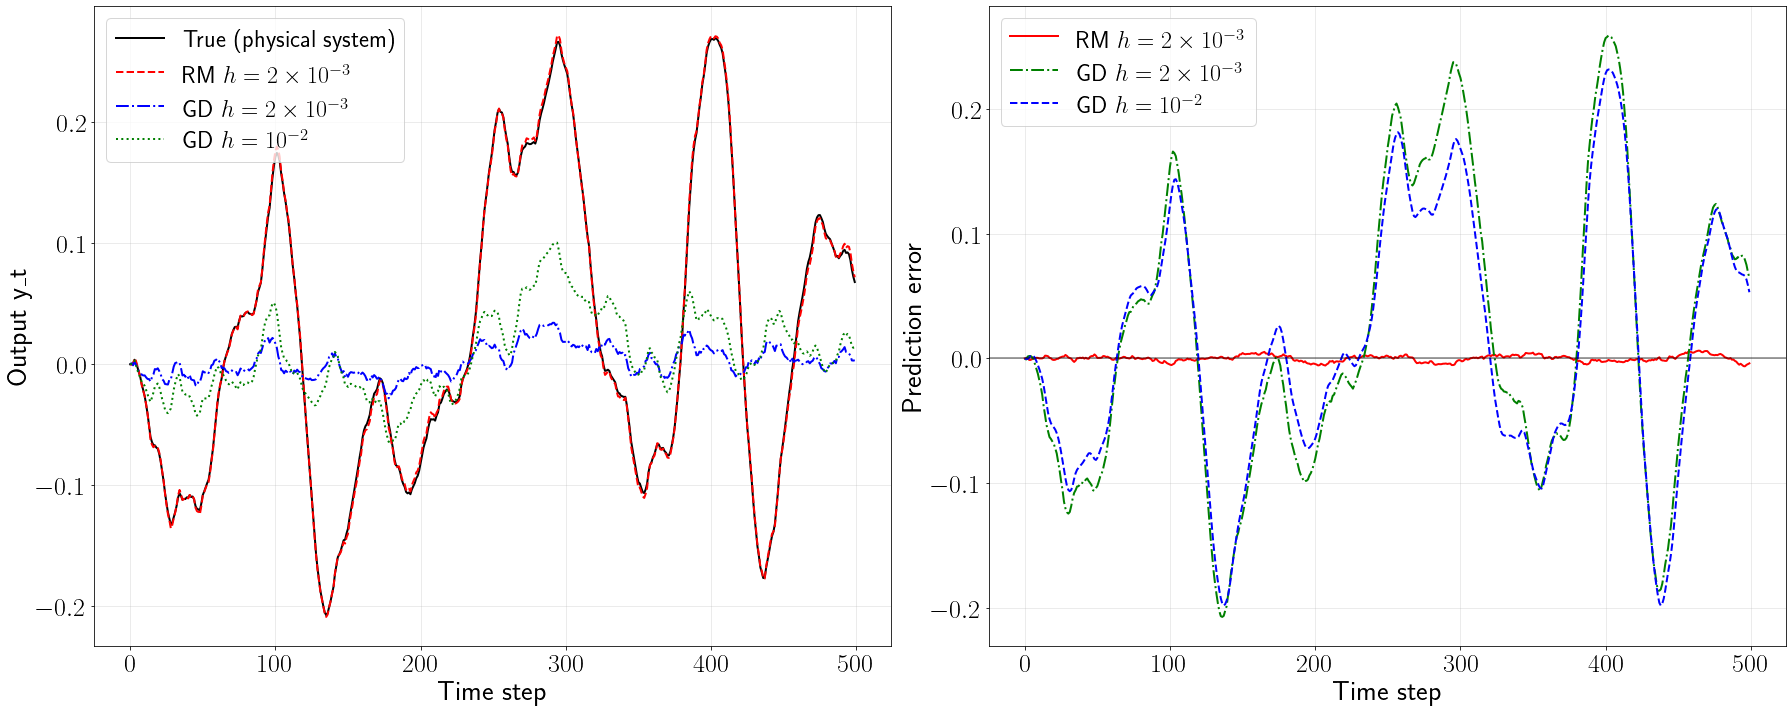

In [344]:
# Plot test sequence comparison
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(y_true, 'k-', linewidth=2, label='True (physical system)')
plt.plot(y_rm, 'r--', linewidth=2, label=r'RM $h=2\times 10^{-3}$')
plt.plot(y_gd, 'b-.', linewidth=2, label=r'GD $h=2\times 10^{-3}$')
plt.plot(y_gd1, 'g:', linewidth=2, label=r'GD $h= 10^{-2}$')
# plt.plot(y_0, 'c-.', linewidth=2, label='Initial guess')
plt.xlabel('Time step', fontdict=font)
plt.ylabel('Output y_t', fontdict=font)
# plt.title('Test sequence comparison')
plt.legend(loc='best', prop=font1)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(y_true - y_rm, 'r-', linewidth=2, label=r'RM $h=2\times 10^{-3}$')
plt.plot(y_true - y_gd, 'g-.', linewidth=2, label=r'GD $h=2\times 10^{-3}$')
plt.plot(y_true - y_gd1, 'b--', linewidth=2, label=r'GD $h=10^{-2}$')
# plt.plot(y_true - y_0, 'c-.', linewidth=2, label='Initial error')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.5)
plt.xlabel('Time step', fontdict=font)
plt.ylabel('Prediction error', fontdict=font)
# plt.title(f'Errors (MSE)')
plt.legend(loc='best', prop=font1)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('LDSI_physical_sequences.pdf', bbox_inches='tight')


In [360]:
# Compute parameter recovery errors
A_rm, C_rm, D_rm = split_params(rm_best, d)
A_gd, C_gd, D_gd = split_params(gd_best, d)

# Spectral norm (operator norm) of A difference
spec_norm_A_rm = np.linalg.norm(A_true - A_rm, ord=2)
spec_norm_A_gd = np.linalg.norm(A_true - A_gd, ord=2)
spec_norm_A_gd1 = np.linalg.norm(A_true - A_gd1, ord=2)
spec_norm_A_0 = np.linalg.norm(A_true - A_hat_0, ord=2)

# Frobenius norm (Euclidean) of A difference  
frob_norm_A_rm = np.linalg.norm(A_true - A_rm, ord='fro')
frob_norm_A_gd = np.linalg.norm(A_true - A_gd, ord='fro')
frob_norm_A_gd1 = np.linalg.norm(A_true - A_gd1, ord='fro')
frob_norm_A_0 = np.linalg.norm(A_true - A_hat_0, ord='fro')

# L2 norm of C difference (C is 1xd)
l2_norm_C_rm = np.linalg.norm(C_true - C_rm, ord=2)
l2_norm_C_gd = np.linalg.norm(C_true - C_gd, ord=2)
l2_norm_C_gd1 = np.linalg.norm(C_true - C_gd1, ord=2)
l2_norm_C_0 = np.linalg.norm(C_true - C_hat_0, ord=2)

# Absolute error on D
abs_err_D_rm = abs(D_true - D_rm)
abs_err_D_gd = abs(D_true - D_gd)
abs_err_D_gd1 = abs(D_true - D_gd1)
abs_err_D_0 = abs(D_true - D_hat_0)

print("\n" + "="*80)
print("PARAMETER RECOVERY ERRORS")
print("="*80)
print(f"{'Metric':<28} {'RM':<11} {'GD':<10} {'GD-l':<10} {'Initial':<12}")
print("-"*80)
print(f"Spectral norm ||A-Â||₂: {spec_norm_A_rm:10.2e}  {spec_norm_A_gd:10.2e}  {spec_norm_A_gd1:10.2e}  {spec_norm_A_0:10.2e}")
print(f"Frobenius norm |A-Â|_F: {frob_norm_A_rm:10.2e}  {frob_norm_A_gd:10.2e}  {frob_norm_A_gd1:10.2e}  {frob_norm_A_0:10.2e}")
print(f"L2 norm ||C-Ĉ||₂:       {l2_norm_C_rm:10.2e}  {l2_norm_C_gd:10.2e}  {l2_norm_C_gd1:10.2e}  {l2_norm_C_0:10.2e}")
print(f"|D-D̂|:                  {abs_err_D_rm:10.2e}  {abs_err_D_gd:10.2e}  {abs_err_D_gd1:10.2e}  {abs_err_D_0:10.2e}")
print("="*80)

# Also print the first 2x2 block (physical part) separately
print("\nMatrix A:")
print("True :")
print(A_true)
print("RM :")
print(A_rm)
print("GD :")
print(A_gd)
print("GD-l :")
print(A_gd1)
print("Initial :")
print(A_hat_0)


PARAMETER RECOVERY ERRORS
Metric                       RM          GD         GD-l       Initial     
--------------------------------------------------------------------------------
Spectral norm ||A-Â||₂:   2.85e-01    2.88e-01    2.89e-01    2.91e-01
Frobenius norm |A-Â|_F:   3.29e-01    3.71e-01    3.65e-01    3.73e-01
L2 norm ||C-Ĉ||₂:         1.33e-01    1.40e-01    1.28e-01    1.35e-01
|D-D̂|:                    1.29e-04    8.01e-04    1.85e-04    6.80e-02

Matrix A:
True :
[[ 1.    0.05  0.    0.  ]
 [-0.1   0.98  0.    0.  ]
 [ 0.    0.    0.5   0.  ]
 [ 0.    0.    0.    0.5 ]]
RM :
[[ 1.04573058  0.04626744  0.1443538  -0.05995029]
 [-0.10706998  0.97437278  0.01491543 -0.07762554]
 [-0.1261056   0.09729444  0.35150459 -0.08739283]
 [-0.03376762  0.12013534 -0.06672383  0.47762432]]
GD :
[[ 0.97117174  0.01941816  0.15914969 -0.07785694]
 [-0.12855595  0.90466486  0.00446887 -0.10549133]
 [-0.13593743  0.08406866  0.33478997 -0.08832543]
 [-0.01395597  0.15137923 -0.0540478

Below we learn a more complex dynamical system of mass-spring-dampers as illusterated in the paper..

In [532]:
N = 200
T = 300
d = 10  # 5 masses × (position + velocity)
T1 = T // 4

# 5 coupled mass-spring-dampers in a chain
n_masses = 5
m = np.array([1.0, 1.1, 1.2, 1.0, 0.9])  # varying masses
k = np.full(n_masses, 2.0)                 # spring constants
c = np.full(n_masses, 0.4)                 # damping coefficients
k_couple = 0.6                             # nearest-neighbor coupling
Ts = 0.05

print(f"5 coupled masses: m={m}, chain dynamics")

# Continuous-time A matrix (10 states: x1,v1,x2,v2,...,x5,v5)
A_cont = np.zeros((d, d))
for i in range(n_masses):
    pos_idx = 2 * i        # x_i
    vel_idx = 2 * i + 1    # v_i
    
    # dx_i/dt = v_i
    A_cont[pos_idx, vel_idx] = 1.0
    
    # dv_i/dt = forces
    # Spring force from own spring (wall for i=0)
    if i == 0:
        A_cont[vel_idx, pos_idx] = -k[0] / m[0]  # wall spring
    else:
        A_cont[vel_idx, pos_idx] = -(k[i] + k_couple) / m[i]
    
    # Coupling from previous mass
    if i > 0:
        A_cont[vel_idx, 2*(i-1)] = k_couple / m[i]  # +k_couple x_{i-1}
    
    # Coupling from next mass  
    if i < n_masses - 1:
        A_cont[vel_idx, 2*(i+1)] = -k_couple / m[i]  # -k_couple x_{i+1}
    
    # Damping
    A_cont[vel_idx, vel_idx] = -c[i] / m[i]

# Input: forces all masses equally
B_cont = np.zeros((d, 1))
B_cont[1::2] = 1.0 / m[:, None]  # velocity inputs

# Discretisation (Euler)
A2 = np.eye(d) + Ts * A_cont
B2 = Ts * B_cont  

# Output: observe middle mass position + some coupling
C2 = np.zeros((1, d))
C2[0, 4] = 1.0    # x3 (middle mass)
C2[0, [0, 2, 6, 8]] = 0.2  # light coupling to others
D2 = 0.0

print("Spectral radius of A2:", spectral_radius(A2))

# Stabilise if needed
rho2 = spectral_radius(A2)
if rho2 >= 1.0:
    A2 = A2 / (rho2 * 1.05)

A_true = A2
B_true = B2
C_true = C2
D_true = D2

print("Spectral radius of A_true:", spectral_radius(A_true))
print("Physical system ready (5 coupled masses, 10 states)")

# Generate training data
x, y = generate_training_data(A_true, B_true, C_true, D_true, N, T, d, T1, noise_std=0.01)


5 coupled masses: m=[1.  1.1 1.2 1.  0.9], chain dynamics
Spectral radius of A2: 1.0077908024249507
Spectral radius of A_true: 0.9523809523809514
Physical system ready (5 coupled masses, 10 states)


In [533]:
def evaluate_loss(theta_hat):
    """
    Loss:
        (1 / (N (T - T1))) sum_{i} sum_{t=T1}^{T-1} (y_hat - y)^2
    with model:
        x_{t+1} = A_hat x_t + B_true u,
        y_hat   = C_hat x_t + D_hat u.
    """
    A_hat, C_hat, D_hat = split_params(theta_hat, d)
    M = x.shape[0]
    Tloc = x.shape[1]

    loss = 0.0
    for i in range(M):
        h_hat = np.zeros((Tloc + 1, d))
        for t in range(T1, Tloc):
            h_hat[t + 1] = (A_hat @ h_hat[t] + (B_true * x[i, t]).reshape(-1)).ravel()
            # C_hat: (1,d), h_hat[t]: (d,), result scalar
            y_hat = (C_hat @ h_hat[t]).item() + D_hat * x[i, t]
            loss += (y_hat - y[i, t]) ** 2
    loss /= (M * (Tloc - T1))
    return loss


def gradient_loss(theta_hat):
    """
    Analytic gradient of the same loss wrt (A,C,D), packed as theta_hat.
    """
    A_hat, C_hat, D_hat = split_params(theta_hat, d)
    M = x.shape[0]
    Tloc = x.shape[1]

    grad_A = np.zeros((d, d))
    grad_C = np.zeros((1, d))
    grad_D = 0.0

    for i in range(M):
        h_hat = np.zeros((Tloc + 1, d))
        for t in range(T1, Tloc):
            h_hat[t + 1] = (A_hat @ h_hat[t] + (B_true * x[i, t]).reshape(-1)).ravel()
            y_hat = (C_hat @ h_hat[t]).item() + D_hat * x[i, t]
            err = y_hat - y[i, t]

            # d/dD
            grad_D += 2.0 * err * x[i, t]
            # d/dC
            grad_C += 2.0 * err * h_hat[t].reshape(1, -1)
            # d/dA: use outer product C_hat^T (d,1) with h_hat[t-1] (1,d)
            grad_A += 2.0 * err * (C_hat.T @ h_hat[t-1].reshape(1, -1))

    grad_A /= (M * (Tloc - T1))
    grad_C /= (M * (Tloc - T1))
    grad_D /= (M * (Tloc - T1))

    return combine_params(grad_A, grad_C, grad_D)

In [538]:
np.random.seed()
epsilon = 0.1

A_hat_0 = A_true + epsilon * np.random.randn(*A_true.shape)
rho_hat = spectral_radius(A_hat_0)
if rho_hat >= 1.0:
    A_hat_0 = A_hat_0 / (rho_hat + 0.05)
print("Spectral radius of A_0:", spectral_radius(A_hat_0))
C_hat_0 = C_true + epsilon * np.random.randn(*C_true.shape)
D_hat_0 = D_true + epsilon * np.random.randn()

theta_hat_0 = combine_params(A_hat_0, C_hat_0, D_hat_0)

init_loss = evaluate_loss(theta_hat_0)
print("Initial loss:", init_loss)

Spectral radius of A_0: 0.9579193746791512
Initial loss: 0.034893824610158226


In [ ]:
num_iterations_rm = 1500
num_iterations_gd = 1500
learning_rate_gd1 = 5e-3     # larger step
learning_rate_gd2 = 1e-3     # smaller step

# RM
start = time.time()
rm_traj = RM(evaluate_loss, theta_hat_0, num_iterations_rm,
             h=1e-3, mu=1e-7, t=1)
rm_time = time.time() - start

rm_losses = np.array([evaluate_loss(rm_traj[:, k])
                      for k in range(num_iterations_rm + 1)])
rm_best_idx = np.argmin(rm_losses)
rm_best = rm_traj[:, rm_best_idx]

print("RM: best loss:", rm_losses[rm_best_idx])
print("RM: final loss:", rm_losses[-1])
print("RM: time (s):", rm_time)

# GD with larger step
w1 = np.zeros((num_iterations_gd, theta_hat_0.size))
w1[0, :] = theta_hat_0.ravel()

start = time.time()
for it in range(num_iterations_gd - 1):
    g = gradient_loss(w1[it, :].reshape(-1, 1)).ravel()
    w1[it + 1, :] = w1[it, :] - learning_rate_gd1 * g
gd1_time = time.time() - start

gd1_losses = np.array([evaluate_loss(w1[it, :])
                       for it in range(num_iterations_gd)])

gd1_best_idx = np.argmin(gd1_losses)
gd1_best = w1[gd1_best_idx, :]

print("GD (lr=5e-3): final loss:", gd1_losses[-1])
print("GD (lr=5e-3): best loss:", gd1_losses[gd1_best_idx])
print("GD (lr=5e-3): time (s):", gd1_time)


# GD with smaller step
w2 = np.zeros((num_iterations_gd, theta_hat_0.size))
w2[0, :] = theta_hat_0.ravel()

start = time.time()
for it in range(num_iterations_gd - 1):
    g = gradient_loss(w2[it, :].reshape(-1, 1)).ravel()
    w2[it + 1, :] = w2[it, :] - learning_rate_gd2 * g
gd2_time = time.time() - start

gd2_losses = np.array([evaluate_loss(w2[it, :])
                       for it in range(num_iterations_gd)])

gd2_best_idx = np.argmin(gd2_losses)
gd_best = w2[gd2_best_idx, :]

print("GD (lr=1e-3): best loss:", gd2_losses[gd2_best_idx])
print("GD (lr=1e-3): final loss:", gd2_losses[-1])
print("GD (lr=1e-3): time (s):", gd2_time)

RM: best loss: 0.0008097879981883498
RM: final loss: 0.0008097879981883498
RM: time (s): 455.3092589378357
GD (lr=1e-2): final loss: 0.006918798106120968
GD (lr=1e-2): best loss: 0.006918798106120968
GD (lr=1e-2): time (s): 524.304532289505
GD (lr=2e-3): best loss: 0.018289821361635563
GD (lr=2e-3): final loss: 0.018289821361635563
GD (lr=2e-3): time (s): 489.90537548065186


In [ ]:
def armijo_gd(func, grad_func, x0, max_iter=1500, alpha0=0.5, beta=0.5, c=1e-4):
    """
    GD with Armijo backtracking line search.
    """
    x_gen=[]
    x = x0.ravel().copy()
    x_gen.append(x)
    losses = [func(x)]
    times = [0.0]
    start_total = time.time()
    
    for it in range(max_iter):
        g = grad_func(x.reshape(-1, 1)).ravel()
        fx = losses[-1]
        
        # Armijo: alpha_k = alpha0 * beta^m where f(x - alpha g) <= f(x) - c alpha ||g||^2
        alpha = alpha0
        x_trial = x - alpha * g
        while func(x_trial) > fx - c * alpha * np.dot(g, g):
            print()
            alpha *= beta
            x_trial = x - alpha * g
            if alpha < 1e-8:  
                break
        
        x = x_trial
        losses.append(func(x))
        x_gen.append(x)
        times.append(time.time() - start_total)
    
    armijo_time = time.time() - start_total
    armijo_best_idx = np.argmin(losses)
    armijo_best = np.array(x_gen)[armijo_best_idx,:]
    
    print("Armijo GD: best loss:", losses[armijo_best_idx])
    print("Armijo GD: final loss:", losses[-1])
    print("Armijo GD: time (s):", armijo_time)
    
    return np.array(losses), np.array(times), armijo_best, np.array(x_gen)


print("GD WITH ARMIJO LINE SEARCH")
print("="*50)
armijo_losses, armijo_times, armijo_best, armijo_x_gen = armijo_gd(
    evaluate_loss, gradient_loss, theta_hat_0, max_iter=1200, alpha0=5e-2)




In [625]:
def RM_armijo(func, x0, max_iter=1500, beta=0.5, c=1e-4, 
              h_base=1e-1, mu=1e-7, t_grad=1):
    """
    RM with Armijo line search on step size h_k.
    """
    x_gen=[]
    x = x0.ravel().copy()
    x_gen.append(x)
    losses = [func(x)]
    times = [0.0]
    start_total = time.time()
    
    for it in range(max_iter):
        fx = losses[-1]

        g = grad(func, x, mu=mu, t=t_grad, fxp=fx) 

        h = h_base
        x_trial = x - h * g
        grad_norm_sq = np.dot(g, g)
        
        while func(x_trial) > fx - c * h * grad_norm_sq:
            h *= beta
            x_trial = x - h * g
            if h < 1e-8:  # Safeguard
                break
        
        x = x_trial
        x_gen.append(x)
        losses.append(func(x))
        times.append(time.time() - start_total)
    
    total_time = time.time() - start_total
    best_idx = np.argmin(losses)
    x_best = np.array(x_gen)[best_idx,:]

    print(f"RM-Armijo: best loss {losses[best_idx]:.2e}, final {losses[-1]:.2e}")
    print(f"RM-Armijo: time {total_time:.1f}s")
    
    return np.array(losses), np.array(times), x_best, np.array(x_gen)


print("RM WITH ARMIJO LINE SEARCH")
print("="*50)
rm_armijo_losses, rm_armijo_times, rm_armijo_best, rm_armijo_gen = RM_armijo(
    evaluate_loss, theta_hat_0, 
    h_base=5e-2, mu=1e-7, t_grad=1, 
    max_iter=1200
)


RM WITH ARMIJO LINE SEARCH
RM-Armijo: best loss 6.00e-04, final 6.00e-04
RM-Armijo: time 749.5s


In [644]:
# Summary table
results = {
    'RM-fixed': rm_losses[rm_best_idx],
    'RM-Armijo': np.min(rm_armijo_losses),
    'GD-large': gd1_losses[gd1_best_idx],
    'GD-small': gd2_losses[gd2_best_idx], 
    'GD-Armijo': np.min(armijo_losses)
}

print("\nFINAL BEST LOSSES:")
for method, loss in results.items():
    print(f"{method:12}: {loss:.2e}")



FINAL BEST LOSSES:
RM-fixed    : 8.10e-04
RM-Armijo   : 6.00e-04
GD-large    : 6.92e-03
GD-small    : 1.83e-02
GD-Armijo   : 9.72e-04


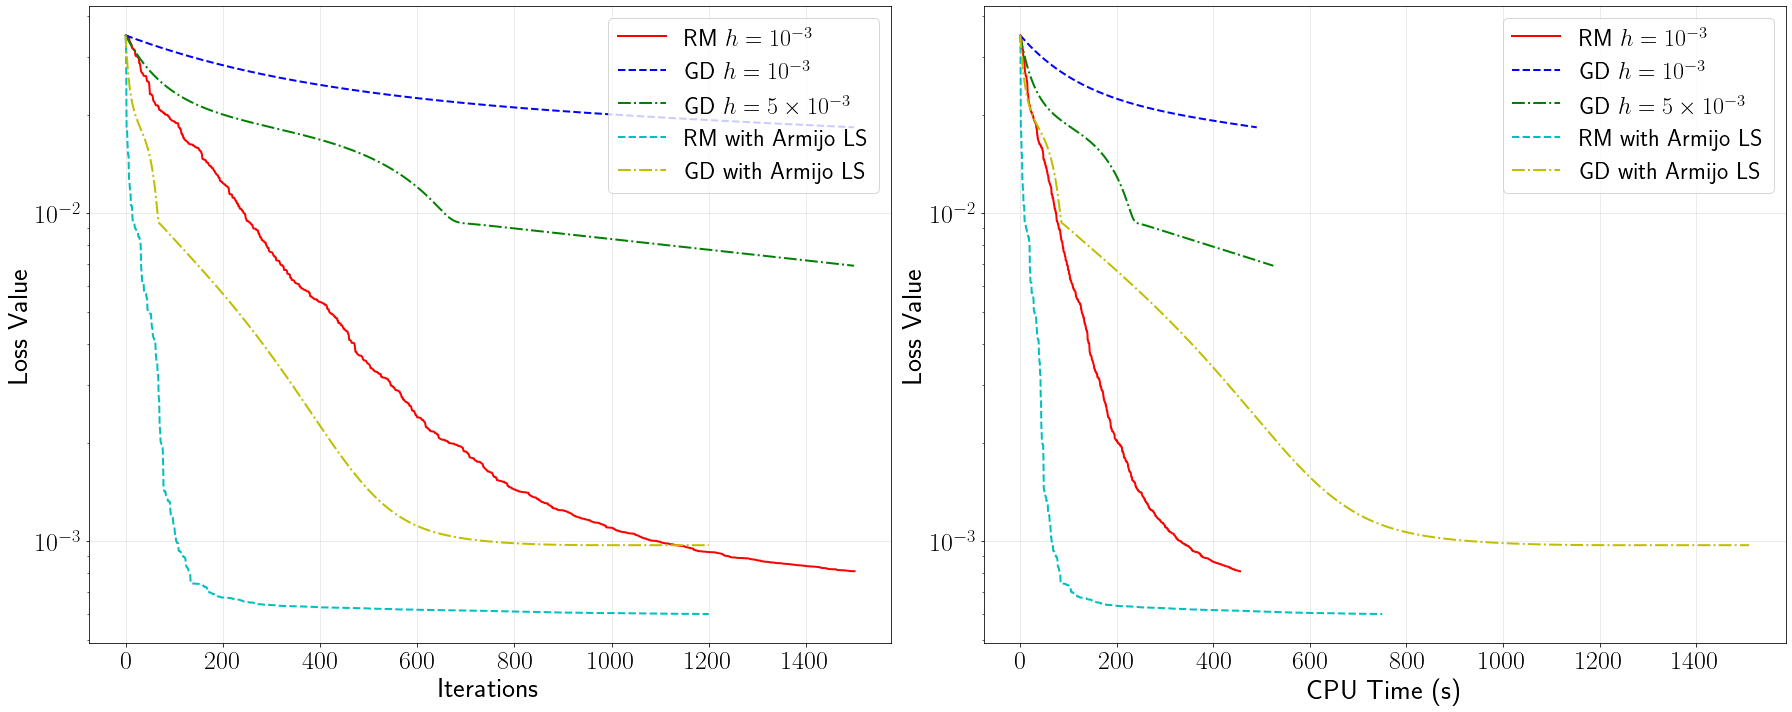

In [662]:
import matplotlib.pyplot as plt

# Plot losses vs iterations
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.semilogy(range(len(rm_losses)), rm_losses, 'r-', linewidth=2, label=r'RM $h= 10^{-3}$')
plt.semilogy(range(len(gd2_losses)), gd2_losses, 'b--', linewidth=2, label=r'GD $h= 10^{-3}$')
plt.semilogy(range(len(gd1_losses)), gd1_losses, 'g-.', linewidth=2, label=r'GD $h=5\times 10^{-3}$')
plt.semilogy(range(len(rm_armijo_losses)), rm_armijo_losses, 'c--', linewidth=2, label='RM with Armijo LS')
plt.semilogy(range(len(armijo_losses)), armijo_losses, 'y-.', linewidth=2, label='GD with Armijo LS')
plt.xlabel('Iterations', fontdict=font)
plt.ylabel('Loss Value', fontdict=font)
# plt.title('LDSI Loss vs Iterations')
plt.legend(loc='upper right', prop=font1)
plt.grid(True, alpha=0.3)

# Plot losses vs CPU time
rm_cumtime = np.linspace(0, rm_time, len(rm_losses))
gd1_cumtime = np.linspace(0, gd1_time, len(gd1_losses))
armijo_cumtime = np.linspace(0, armijo_times[-1], len(armijo_losses))
rm_armijo_cumtime = np.linspace(0, rm_armijo_times[-1], len(rm_armijo_losses))

plt.subplot(1, 2, 2)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.semilogy(rm_cumtime, rm_losses, 'r-', linewidth=2, label=r'RM $h= 10^{-3}$')
plt.semilogy(gd2_cumtime, gd2_losses, 'b--', linewidth=2, label=r'GD $h= 10^{-3}$')
plt.semilogy(gd1_cumtime, gd1_losses, 'g-.', linewidth=2, label=r'GD $h=5\times 10^{-3}$')
plt.semilogy(rm_armijo_cumtime, rm_armijo_losses, 'c--', linewidth=2, label='RM with Armijo LS')
plt.semilogy(armijo_cumtime, armijo_losses, 'y-.', linewidth=2, label='GD with Armijo LS')
plt.xlabel('CPU Time (s)', fontdict=font)
plt.ylabel('Loss Value', fontdict=font)
# plt.title('LDSI Loss vs CPU Time')
plt.legend(loc='best', prop=font1)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('LDSI_physical_losses_comp.pdf', bbox_inches='tight')


In [663]:
def simulate_system(A, B, C, D, u):
    """
    Simulate one trajectory:
        x_{t+1} = A x_t + B u_t
        y_t     = C x_t + D u_t
    with x_0 = 0.
    """
    dloc = A.shape[0]
    Tloc = u.size
    x_state = np.zeros((Tloc + 1, dloc))
    y_out = np.zeros(Tloc)
    for t in range(Tloc):
        x_state[t + 1] = (A @ x_state[t] + (B * u[t]).reshape(-1)).ravel()
        y_out[t] = (C @ x_state[t]).item() + D * u[t]
    return x_state, y_out

In [695]:
T_test = 500
u_test = np.random.randn(T_test)


x_true, y_true = simulate_system(A_true, B_true, C_true, D_true, u_test)
x_0, y_0 = simulate_system(A_hat_0, B_true, C_hat_0, D_hat_0, u_test)

A_rm, C_rm, D_rm = split_params(rm_best, d)
C_rm = C_rm.reshape(1, -1)
_, y_rm = simulate_system(A_rm, B_true, C_rm, D_rm, u_test)

A_gd, C_gd, D_gd = split_params(gd_best, d)
C_gd = C_gd.reshape(1, -1)
_, y_gd = simulate_system(A_gd, B_true, C_gd, D_gd, u_test)


A_gd1, C_gd1, D_gd1 = split_params(gd1_best, d)
C_gd1 = C_gd1.reshape(1, -1)
_, y_gd1 = simulate_system(A_gd1, B_true, C_gd1, D_gd1, u_test)


A_arm, C_arm, D_arm = split_params(armijo_best, d)
C_arm = C_arm.reshape(1, -1)
_, y_arm = simulate_system(A_arm, B_true, C_arm, D_arm, u_test)

A_rm_arm, C_rm_arm, D_rm_arm = split_params(rm_armijo_best, d)
C_rm_arm = C_rm_arm.reshape(1, -1)
_, y_rm_arm = simulate_system(A_rm_arm, B_true, C_rm_arm, D_rm_arm, u_test)

mse_00 = np.mean((y_0 - y_true) ** 2)
mse_rm = np.mean((y_rm - y_true) ** 2)
mse_gd = np.mean((y_gd - y_true) ** 2)
mse_gd1 = np.mean((y_gd1 - y_true) ** 2)
mse_arm = np.mean((y_arm - y_true) ** 2)
mse_rm_arm = np.mean((y_rm_arm - y_true) ** 2)

print("Test MSE (initial guess vs true):", mse_00)
print("Test MSE (RM vs true):", mse_rm)
print("Test MSE (GD vs true):", mse_gd)
print("Test MSE (GD-l vs true):", mse_gd1)
print("Test MSE (GD-Armijo vs true):", mse_arm)
print("Test MSE (RM-Armijo vs true):", mse_rm_arm)

Test MSE (initial guess vs true): 0.05342237866164486
Test MSE (RM vs true): 0.00029570444661791294
Test MSE (GD vs true): 0.039814216070782886
Test MSE (GD-l vs true): 0.014652662598223468
Test MSE (GD-Armijo vs true): 0.0007846272431550328
Test MSE (RM-Armijo vs true): 1.5570921571080558e-05


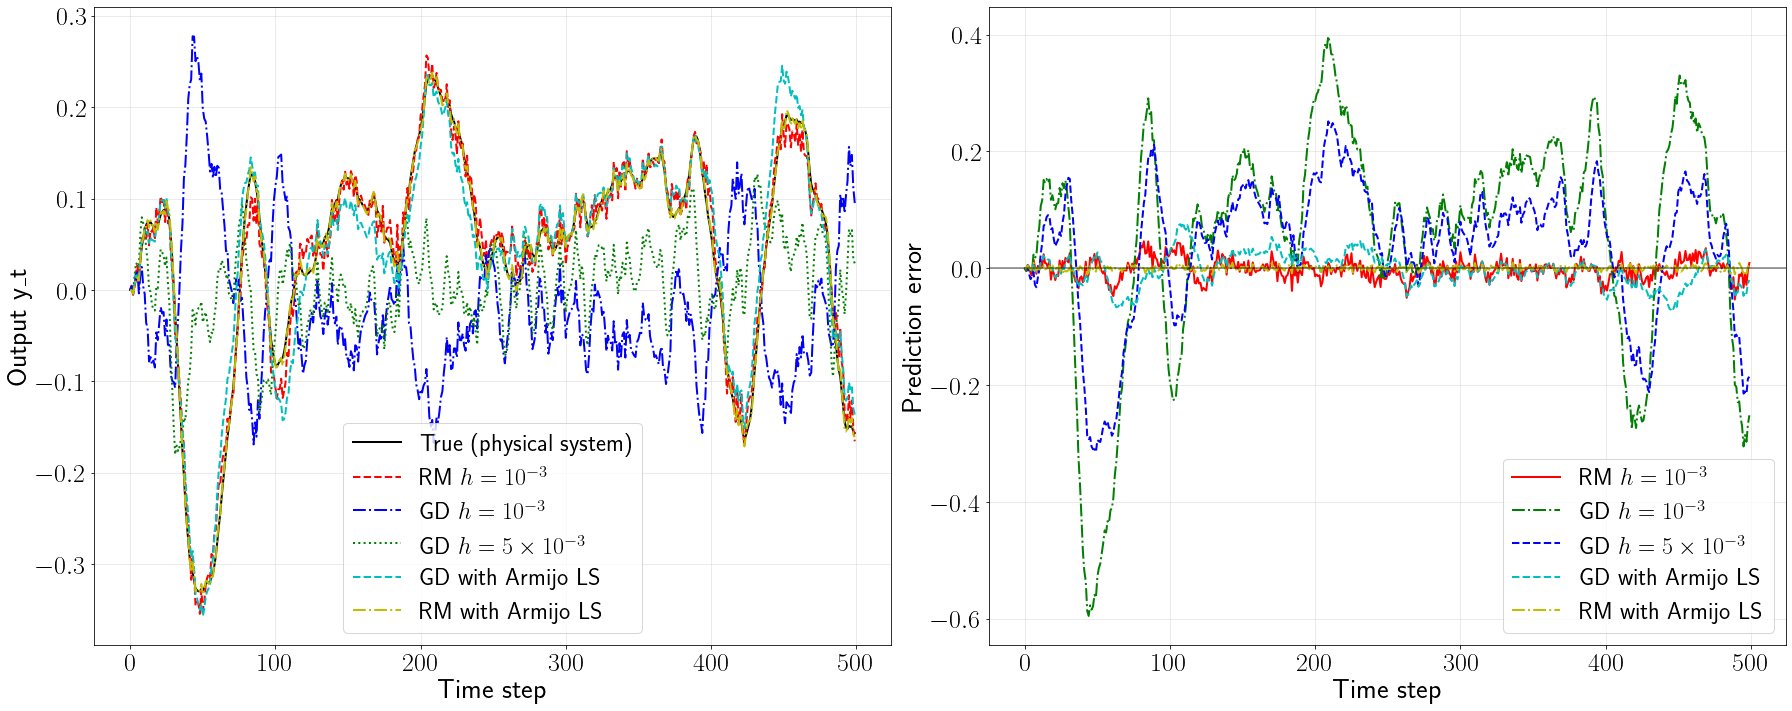

In [696]:
# Plot test sequence comparison
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(y_true, 'k-', linewidth=2, label='True (physical system)')
plt.plot(y_rm, 'r--', linewidth=2, label=r'RM $h= 10^{-3}$')
plt.plot(y_gd, 'b-.', linewidth=2, label=r'GD $h=10^{-3}$')
plt.plot(y_gd1, 'g:', linewidth=2, label=r'GD $h=5\times 10^{-3}$')
plt.plot(y_arm, 'c--', linewidth=2, label=r'GD with Armijo LS')
plt.plot(y_rm_arm, 'y-.', linewidth=2, label='RM with Armijo LS')
# plt.plot(y_0, 'c-.', linewidth=2, label='Initial guess')
plt.xlabel('Time step', fontdict=font)
plt.ylabel('Output y_t', fontdict=font)
# plt.title('Test sequence comparison')
plt.legend(loc='best', prop=font1)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.xticks(fontname='serif', fontsize=26, color='black')
plt.yticks(fontname='serif', fontsize=26, color='black')
plt.plot(y_true - y_rm, 'r-', linewidth=2, label=r'RM $h= 10^{-3}$')
plt.plot(y_true - y_gd, 'g-.', linewidth=2, label=r'GD $h= 10^{-3}$')
plt.plot(y_true - y_gd1, 'b--', linewidth=2, label=r'GD $h=5\times 10^{-3}$')
plt.plot(y_true - y_arm, 'c--', linewidth=2, label='GD with Armijo LS')
plt.plot(y_true - y_rm_arm, 'y-.', linewidth=2, label='RM with Armijo LS')
# plt.plot(y_true - y_0, 'c-.', linewidth=2, label='Initial error')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.5)
plt.xlabel('Time step', fontdict=font)
plt.ylabel('Prediction error', fontdict=font)
# plt.title(f'Errors (MSE)')
plt.legend(loc='best', prop=font1)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('LDSI_physical_sequences_comp.pdf', bbox_inches='tight')


In [703]:
# Compute parameter recovery errors
A_rm, C_rm, D_rm = split_params(rm_best, d)
A_gd, C_gd, D_gd = split_params(gd_best, d)
A_gd1, C_gd1, D_gd1 = split_params(gd1_best, d)
A_arm, C_arm, D_arm = split_params(armijo_best, d)
A_rm_arm, C_rm_arm, D_rm_arm = split_params(rm_armijo_best, d)

# Spectral norm (operator norm) of A difference
spec_norm_A_rm = np.linalg.norm(A_true - A_rm, ord=2)
spec_norm_A_gd = np.linalg.norm(A_true - A_gd, ord=2)
spec_norm_A_gd1 = np.linalg.norm(A_true - A_gd1, ord=2)
spec_norm_A_0 = np.linalg.norm(A_true - A_hat_0, ord=2)
spec_norm_A_arm = np.linalg.norm(A_true - A_arm, ord=2)
spec_norm_A_rm_arm = np.linalg.norm(A_true - A_rm_arm, ord=2)

# Frobenius norm (Euclidean) of A difference  
frob_norm_A_rm = np.linalg.norm(A_true - A_rm, ord='fro')
frob_norm_A_gd = np.linalg.norm(A_true - A_gd, ord='fro')
frob_norm_A_gd1 = np.linalg.norm(A_true - A_gd1, ord='fro')
frob_norm_A_0 = np.linalg.norm(A_true - A_hat_0, ord='fro')
frob_norm_A_arm = np.linalg.norm(A_true - A_arm, ord='fro')
frob_norm_A_rm_arm = np.linalg.norm(A_true - A_rm_arm, ord='fro')

# L2 norm of C difference (C is 1xd)
l2_norm_C_rm = np.linalg.norm(C_true - C_rm, ord=2)
l2_norm_C_gd = np.linalg.norm(C_true - C_gd, ord=2)
l2_norm_C_gd1 = np.linalg.norm(C_true - C_gd1, ord=2)
l2_norm_C_0 = np.linalg.norm(C_true - C_hat_0, ord=2)
l2_norm_C_arm = np.linalg.norm(C_true - C_arm, ord=2)
l2_norm_C_rm_arm = np.linalg.norm(C_true - C_rm_arm, ord=2)

# Absolute error on D
abs_err_D_rm = abs(D_true - D_rm)
abs_err_D_gd = abs(D_true - D_gd)
abs_err_D_gd1 = abs(D_true - D_gd1)
abs_err_D_0 = abs(D_true - D_hat_0)
abs_err_D_arm = abs(D_true - D_arm)
abs_err_D_rm_arm = abs(D_true - D_rm_arm)

print("\n" + "="*80)
print("PARAMETER RECOVERY ERRORS")
print("="*80)
print(f"{'Metric':<28} {'RM':<8} {'RM-Armijo':<12} {'GD':<10} {'GD-l':<10} {'GD-Armijo':<12} {'Initial':<12}")
print("-"*80)
print(f"Spectral norm ||A-Â||₂: {spec_norm_A_rm:10.2e}  {spec_norm_A_rm_arm:10.2e}  {spec_norm_A_gd:10.2e}  {spec_norm_A_gd1:10.2e}  {spec_norm_A_arm:10.2e}  {spec_norm_A_0:10.2e}")
print(f"Frobenius norm |A-Â|_F: {frob_norm_A_rm:10.2e}  {frob_norm_A_rm_arm:10.2e}  {frob_norm_A_gd:10.2e}  {frob_norm_A_gd1:10.2e}  {frob_norm_A_arm:10.2e}  {frob_norm_A_0:10.2e}")
print(f"L2 norm ||C-Ĉ||₂:       {l2_norm_C_rm:10.2e}  {l2_norm_C_rm_arm:10.2e}  {l2_norm_C_gd:10.2e}  {l2_norm_C_gd1:10.2e}  {l2_norm_C_arm:10.2e}  {l2_norm_C_0:10.2e}")
print(f"|D-D̂|:                  {abs_err_D_rm:10.2e}  {abs_err_D_rm_arm:10.2e}  {abs_err_D_gd:10.2e}  {abs_err_D_gd1:10.2e}  {abs_err_D_arm:10.2e}  {abs_err_D_0:10.2e}")
print("="*80)



PARAMETER RECOVERY ERRORS
Metric                       RM       RM-Armijo    GD         GD-l       GD-Armijo    Initial     
--------------------------------------------------------------------------------
Spectral norm ||A-Â||₂:   4.59e-01    5.33e-01    4.58e-01    4.59e-01    4.67e-01    4.58e-01
Frobenius norm |A-Â|_F:   8.89e-01    1.04e+00    8.86e-01    8.80e-01    8.76e-01    8.89e-01
L2 norm ||C-Ĉ||₂:         2.65e-01    2.45e-01    2.71e-01    2.89e-01    3.70e-01    2.61e-01
|D-D̂|:                    4.60e-03    1.97e-04    3.96e-03    3.11e-05    4.32e-05    8.25e-02
